In [27]:
import pandas as pd
import numpy as np
import networkx as nx
import sys
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/work/ccnr/glover.co/net_design/NetDesign')
import network_design as nd

In [9]:
data = np.loadtxt('../../data/pollinator_network/M_PL_074_12.csv',delimiter=',')

NetworkXError: Adjacency matrix not square: nx,ny=(26, 12)

In [13]:
A = np.zeros((data.shape[0]+data.shape[1],data.shape[0]+data.shape[1]))

In [16]:
A[:data.shape[0],-data.shape[1]:] = data
A[data.shape[0]:,:-data.shape[1]] = data.T

In [18]:
g = nx.from_numpy_array(A)

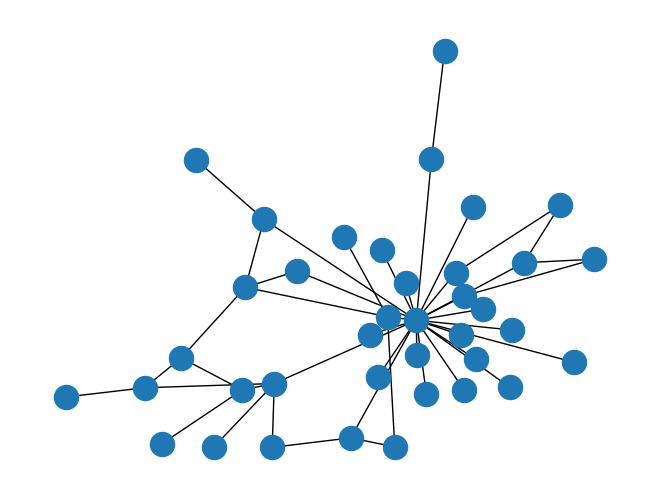

In [19]:
nx.draw(g)

In [20]:
X = np.eye(g.number_of_nodes())

In [22]:
new_X = np.tile(X,(5,1))

In [24]:
O = nd.extract_O(g,X)

In [59]:
test = nd.NetAssembly(new_X,O,new_X.sum(axis=0,dtype=int),system_energy=1)

In [60]:
test.run(100000,link_strength=.01,component=False)

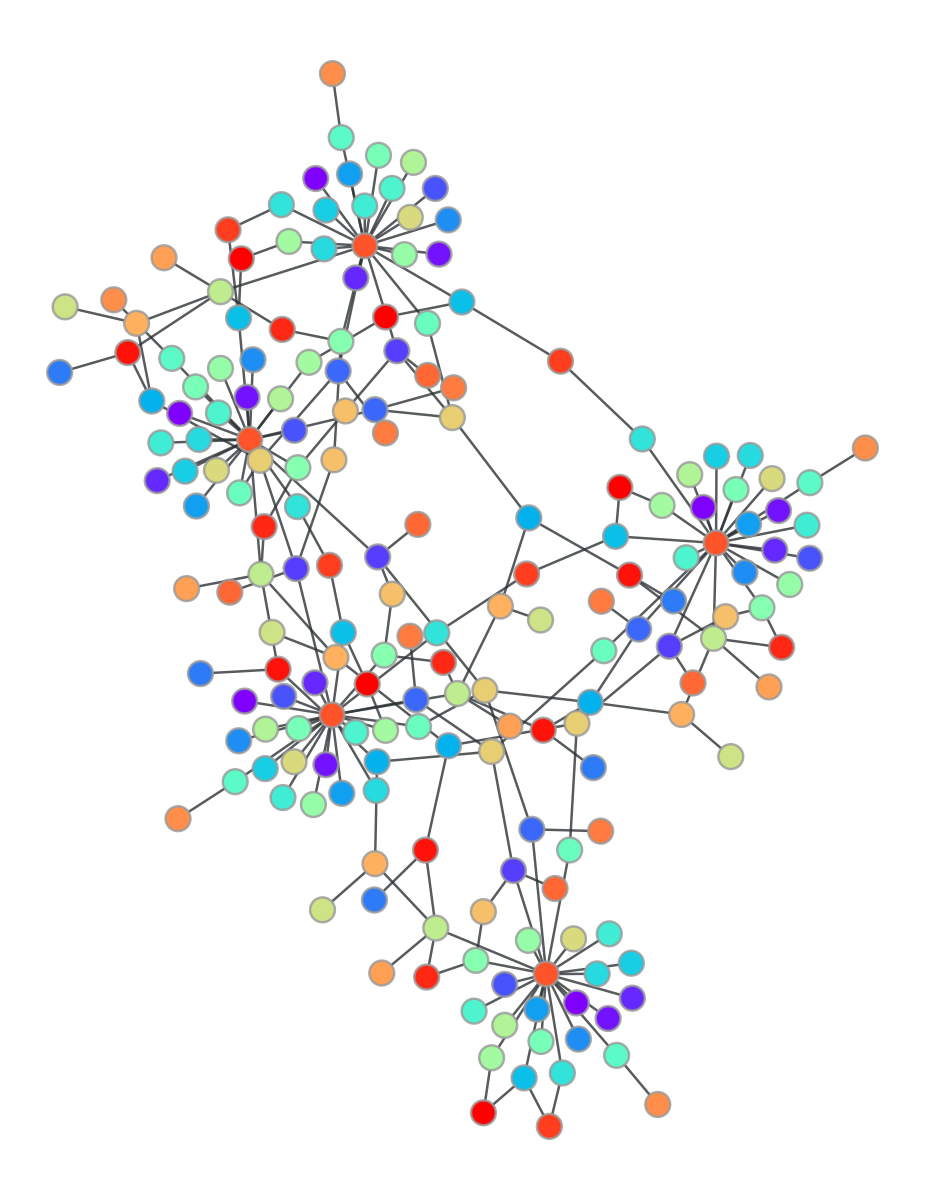

<Figure size 500x500 with 0 Axes>

In [61]:
test.draw(with_networkx=False)

In [37]:
new_obj = nd.NetAssembly(X,O,X.sum(axis=0,dtype=int))

In [38]:
new_obj.g = g

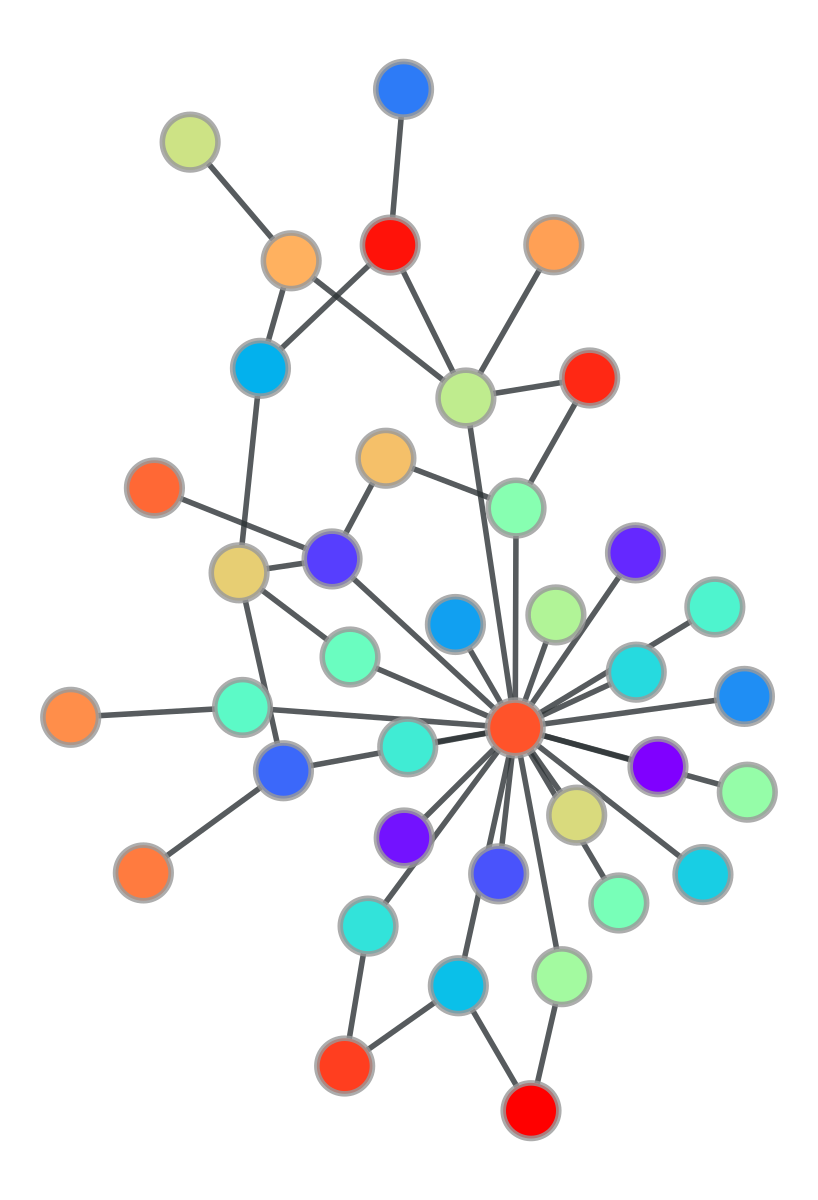

<Figure size 500x500 with 0 Axes>

In [39]:
new_obj.draw(with_networkx=False)